In [2]:
import pathlib
import re
from collections import Counter
from functools import partial
import string

from tqdm.notebook import tqdm, trange

from unidecode import unidecode
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef

In [3]:
def show_tensor(X, title=''):
    plt.imshow(X.detach().numpy())
    plt.title(title)
    plt.show()

In [4]:
file_paths = list((pathlib.Path('.') / 'data' / 'names').glob('*.txt'))

In [5]:
df = pd.DataFrame(columns=['name', 'nat'])
for fp in file_paths:
    d = pd.read_csv(fp, on_bad_lines='warn', names=['name'])
    d['nat'] = fp.stem.lower()
    df = pd.concat([df, d], axis=0)

/tmp/ipykernel_12550/108085630.py:3: ParserWarning: Skipping line 4395: expected 1 fields, saw 2
Skipping line 5236: expected 1 fields, saw 2
Skipping line 5255: expected 1 fields, saw 2

  d = pd.read_csv(fp, on_bad_lines='warn', names=['name'])


In [6]:
# Data issues:
# - "d'" -> "ď"
# - stray strings eg. "To The First  Page"
# - incorrect translitteration eg. "'" -> [russian soft sign]
    
df['name_ascii'] = df['name'].apply(unidecode)
df['name_ascii'] = df['name_ascii'].apply(lambda s: re.sub(r'[^a-zA-Z]', '', s))

df[df['name_ascii'] != df['name']]

df['name_ascii'] = df['name_ascii'].str.lower()

{'k': 0, 'h': 1, 'o': 2, 'u': 3, 'r': 4, 'y': 5, 'n': 6, 'a': 7, 's': 8, 'd': 9, 'e': 10, 'g': 11, 'z': 12, 'i': 13, 'm': 14, 'l': 15, 'f': 16, 'b': 17, 't': 18, 'w': 19, 'j': 20, 'c': 21, 'q': 22, 'p': 23, 'x': 24, 'v': 25}
wat


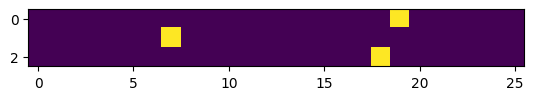

{'arabic': 0,
 'chinese': 1,
 'czech': 2,
 'dutch': 3,
 'english': 4,
 'french': 5,
 'german': 6,
 'greek': 7,
 'irish': 8,
 'italian': 9,
 'japanese': 10,
 'korean': 11,
 'polish': 12,
 'portuguese': 13,
 'russian': 14,
 'scottish': 15,
 'spanish': 16,
 'vietnamese': 17}

{'russian': 9405, 'english': 3668, 'arabic': 2000, 'japanese': 991, 'german': 724, 'italian': 709, 'czech': 519, 'spanish': 298, 'dutch': 297, 'french': 277, 'chinese': 268, 'irish': 232, 'greek': 203, 'polish': 139, 'scottish': 100, 'korean': 94, 'portuguese': 74, 'vietnamese': 73}
[0.0005, 0.0037313432835820895, 0.0019267822736030828, 0.003367003367003367, 0.0002726281352235551, 0.0036101083032490976, 0.0013812154696132596, 0.0049261083743842365, 0.004310344827586207, 0.0014104372355430183, 0.0010090817356205853, 0.010638297872340425, 0.007194244604316547, 0.013513513513513514, 0.0001063264221158958, 0.01, 0.003355704697986577, 0.0136986301369863]


In [7]:
letter_counter = Counter()
for s in df['name_ascii']:
    letter_counter.update(s)
chars = string.ascii_letters + " .,;'"

letter_map = {l: i for i, l in enumerate(letter_counter)}
nat_map = {n: i for i, n in enumerate(df['nat'].unique())}
nat_map_i = {v: k for k, v in nat_map.items()}

def nat_to_tensor(nat, nat_map):
    tens = F.one_hot(torch.tensor([nat_map[nat]]), num_classes=len(nat_map)).squeeze()
    return tens.to(dtype=torch.float)
nat_to_tensor = partial(nat_to_tensor, nat_map=nat_map)
              
def str_to_tensor(w, letter_map):
    try:
        indices = [letter_map[l] for l in w]
    except Exception:
        print(w)
        raise
    tens = F.one_hot(torch.tensor(indices), num_classes=len(letter_map))
    return tens.to(dtype=torch.float)
str_to_tensor = partial(str_to_tensor, letter_map=letter_map)

nat_counts = df['nat'].value_counts().to_dict()
weights = [1 / nat_counts[k] for k in nat_map.keys()]

print(letter_map)
print('wat')

show_tensor(str_to_tensor('wat'))

display(nat_map)
print(nat_counts)
print(weights)

In [27]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super().__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=self.num_layers)
        self.h2o = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        output, hidden = self.lstm(input, hidden)
        output = self.h2o(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(self.num_layers, self.hidden_size)


hidden_size = 64
rnn = RNN(
    input_size=len(letter_map),
    hidden_size=hidden_size,
    output_size=len(nat_map),
    num_layers=1,
)

torch.Size([3, 26])

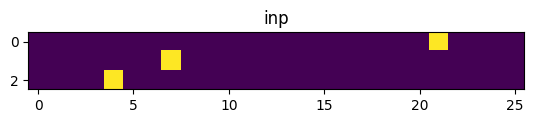

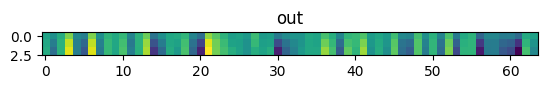

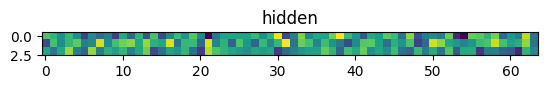

In [11]:
inp = str_to_tensor('car')
out, hidden = rnn(inp, rnn.init_hidden())

display(inp.size())

show_tensor(inp, 'inp')
show_tensor(out, 'out')
show_tensor(hidden, 'hidden')

In [12]:
split = int(df.shape[0] * 0.8)
print(f'Train split: {split}/{df.shape[0]}')
df_s = df.sample(frac=1, ignore_index=True)

df_train = df_s.iloc[:split]
df_test = df_s.iloc[split:]

Train split: 16056/20071


In [28]:
lr = 0.001
optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(weight=torch.tensor(weights), reduction='mean')

def fwd(X):
    hidden = rnn.init_hidden()
    output, hidden = rnn.forward(X, hidden)
    return output[-1]


def train(X, y):

    optimizer.zero_grad()

    output = fwd(X)

    output = output.squeeze()
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()

    return output, loss.item()

losses = []

rnn.train()
epochs = 10
e_pbar = trange(epochs)
for e in e_pbar:
    epoch_losses = []
    b_pbar = tqdm(df_train.iterrows(), total=len(df_train), display=True)
    for i, row in b_pbar:
        X = str_to_tensor(row['name_ascii'])
        #y = nat_to_tensor(row['nat'])
        y = torch.tensor(nat_map[row['nat']])

        output, loss = train(X, y)
        epoch_losses.append(loss)
        b_pbar.set_description(f"loss: {np.mean(epoch_losses[-100:]).item():.4}")

    losses.append(np.mean(epoch_losses).item())
    e_pbar.set_description(f"loss: {losses[-1]:.4}")

    #eval(df_train[:3])

plt.plot(losses)
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/16056 [00:00<?, ?it/s]

IndexError: index 1 is out of bounds for dimension 0 with size 1

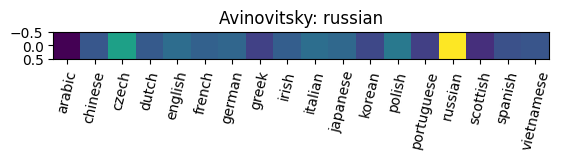

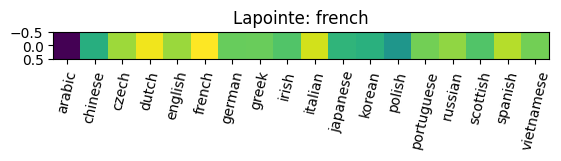

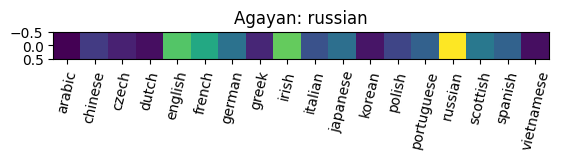

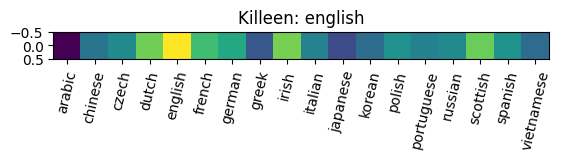

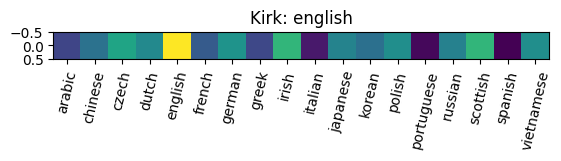

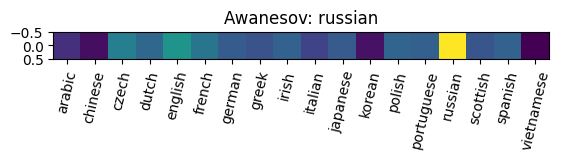

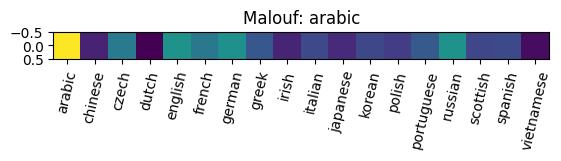

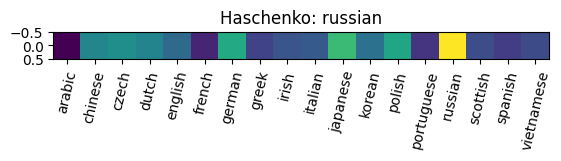

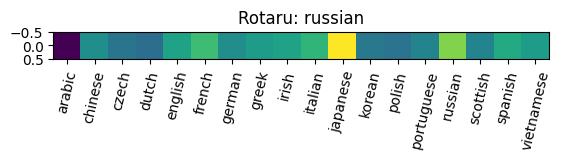

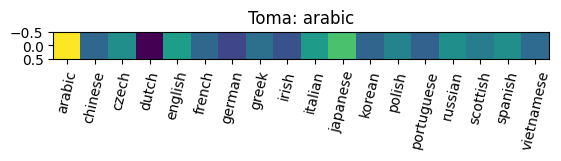

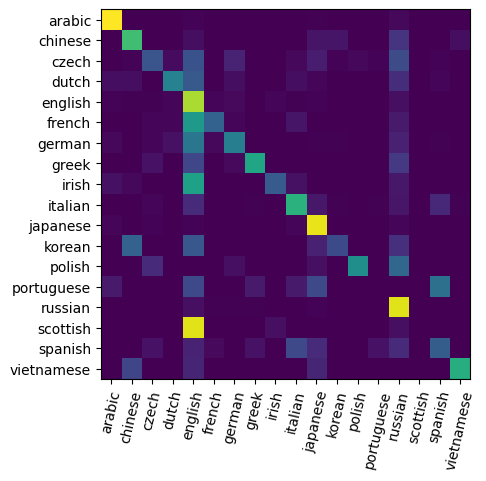

In [23]:
def eval(df):
    for i, row in tqdm(df.iterrows(), total=len(df), display=False):
        X = str_to_tensor(row['name_ascii'])
        y = nat_to_tensor(row['nat'])

        y_ = fwd(X)
        plt.xticks(list(nat_map.values()), labels=list(nat_map.keys()), rotation=77)
        show_tensor(y_.unsqueeze(0), f"{row['name']}: {row['nat']}")
        

eval(df_test[:10])

true_y = df_test['nat'].apply(lambda x: nat_map[x])
pred_y = df_test['name_ascii'].apply(lambda x: torch.argmax(fwd(str_to_tensor(x))).item())

cm = confusion_matrix(true_y, pred_y, labels=list(nat_map.values()), sample_weight=[weights[n] for n in true_y], normalize='true')
plt.imshow(cm)
plt.xticks(list(nat_map.values()), labels=list(nat_map.keys()), rotation=77)
plt.yticks(list(nat_map.values()), labels=list(nat_map.keys()))
plt.show()

In [24]:
rep = pd.merge(true_y, pred_y, left_index=True, right_index=True)
rep[:30]

,nat,name_ascii
16056,14,14
16057,5,5
16058,14,14
16059,4,4
16060,4,4
16061,14,14
16062,0,0
16063,14,14
16064,14,10
16065,0,0
